# Bayesian Linear Regression Example 

Walkthrough of the important bits of the [Linear Regression tutorial from the numpyro docs](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Predictive-Utility-With-Effect-Handlers) purely for practice.



In [11]:
import os

# from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")

In [12]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")

# standardize dataset
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

dset.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,AgeScaled,MarriageScaled,DivorceScaled
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.266989,-0.927058


In [13]:
# MODEL
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = numpyro.deterministic('mu', a + M + A)
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

Draw the graph using `numpyro.render_model` and pass in the model (and model arguments) as needed:

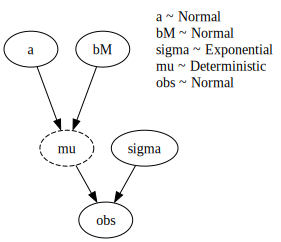

In [14]:
numpyro.render_model(model, (dset['MarriageScaled'].values,), render_distributions=True)

In [15]:
# Get Samples

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key, 2)

# Run the sampler
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

# Regress divorce rate as a function of marriage rate
mcmc.run(rng_key_,
         marriage=dset['MarriageScaled'].values, # must be an array, not a series
         divorce=dset['DivorceScaled'].values)

# print summary
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2251.94it/s, 3 steps of size 6.91e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.00     -0.18      0.18   1387.90      1.00
        bM      0.35      0.13      0.34      0.14      0.57   1841.97      1.00
     sigma      0.95      0.10      0.94      0.79      1.10   1624.28      1.00

Number of divergences: 0


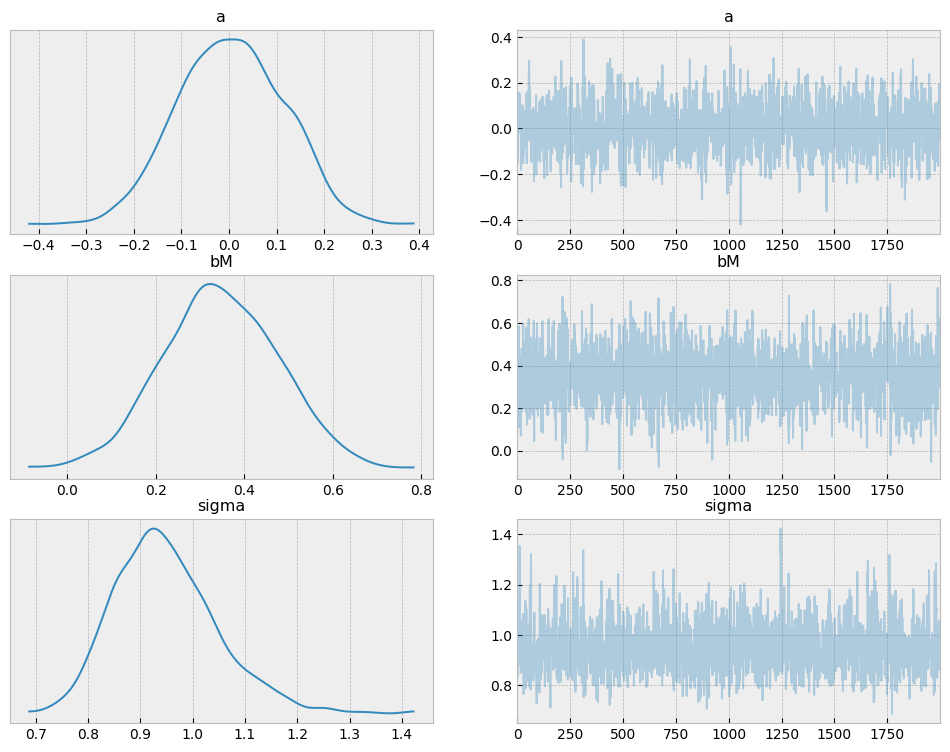

In [16]:
import arviz as az

az.plot_trace(mcmc, figsize=(12,9), var_names=['a', 'bM', 'sigma']);

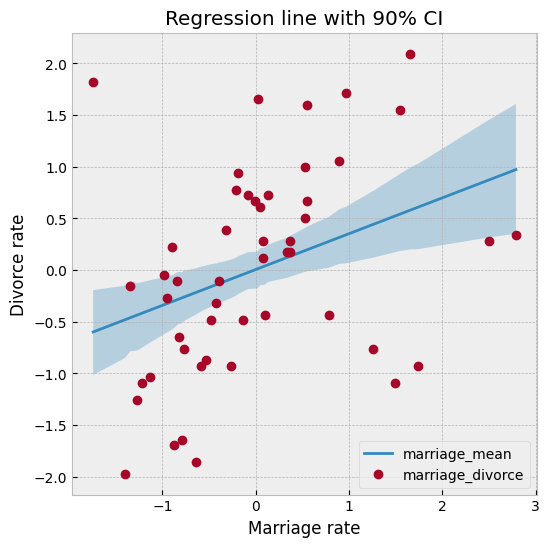

In [17]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean, label='marriage_mean')
    ax.plot(marriage, divorce, "o", label='marriage_divorce')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    ax.legend()
    return ax


# Compute empirical posterior distribution over mu by
# computing from the samples
posterior_mu = mcmc.get_samples()['mu']

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)  # (2, 50)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
);

## Prior Predictive Checks

`Predictive` Helper class


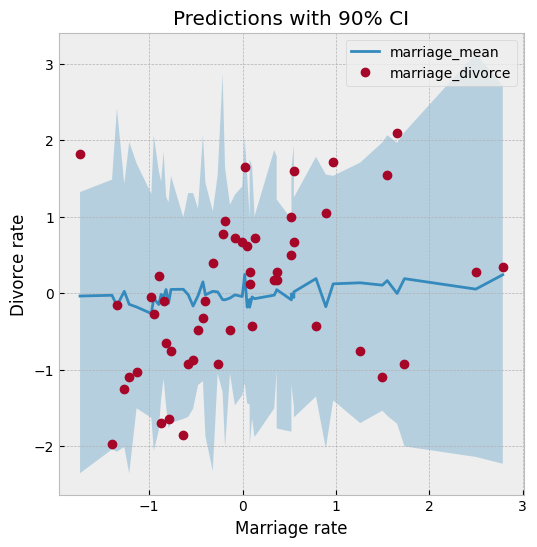

In [18]:

from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

## Posterior Predictive Sampling

The `Predictive` helper class will output posterior *predictive* samples if you give it the posterior samples as an argument (for prior predictive, we just let it know the number of samples)

In [19]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.016637
1,Alaska,0.502172
2,Arizona,0.024746
3,Arkansas,0.598174
4,California,-0.082400


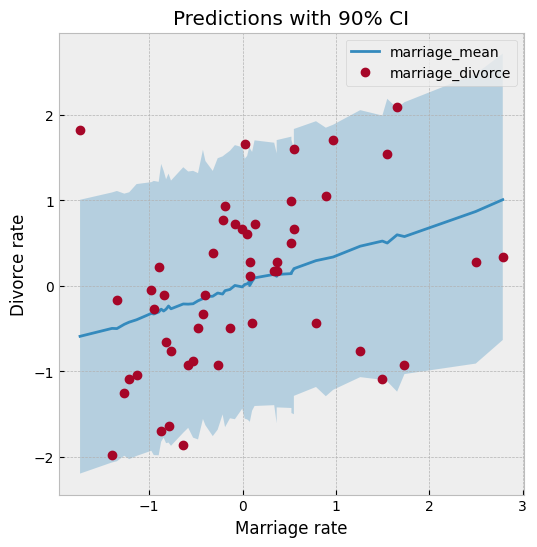

In [10]:
hpdi_pred = hpdi(predictions, 0.9)
mean_pred = jnp.mean(predictions, axis=0)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

# Splines

Here we take another example from the `numpyro` translation of *Rethinking* 2nd ed, using the cherry blossom bloom date dataset:

In [11]:
d = pd.read_csv("https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/cherry_blossoms.csv", sep=';')
d.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1215.0,1408.000000,350.884596,801.00,1104.50,1408.000,1711.5000,2015.00
doy,827.0,104.540508,6.407036,86.00,100.00,105.000,109.0000,124.00
temp,1124.0,6.141886,0.663648,4.67,5.70,6.100,6.5300,8.30
temp_upper,1124.0,7.185151,0.992921,5.45,6.48,7.040,7.7200,12.10
temp_lower,1124.0,5.098941,0.850350,0.75,4.61,5.145,5.5425,7.74


Here using 15 knots and split up the years into quantiles:

In [12]:
# 4.73
d2 = d[d.doy.notna()]  # complete cases on doy
num_knots = 15
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=num_knots)
)

Here we create a Degree 3 (cubic) spline using `scipy.interpolate.BSpline`

In [13]:
knot_list

Array([ 812.    , 1036.0001, 1174.    , 1269.    , 1377.    , 1454.    ,
       1518.    , 1583.    , 1650.0001, 1714.    , 1774.    , 1833.0001,
       1893.0001, 1956.    , 2015.    ], dtype=float32)

Recall the formula for a basis spline: $S(x) = \sum_{j=0}^{n-1} c_j  B_{j, k; t}(x)$ with knots $t$, spline coefficients $c$, and degree $k$

In [14]:
# 4.74
from scipy.interpolate import BSpline

# pad the beginning and end k times
knots = jnp.pad(knot_list, (3, 3), mode="edge") 
spline = BSpline(t=knots, c=jnp.identity(num_knots + 2), k=3)
B = spline(d2.year.values)
B.shape

(827, 17)

So we have an (827, 17) Basis matrix where each row is a year, each column is a basis function, one of our synthetic variables defining a span of years within which a corresponding parameter will influence prediction

To visualize, we plot each column (i.e. each basis function) against year:

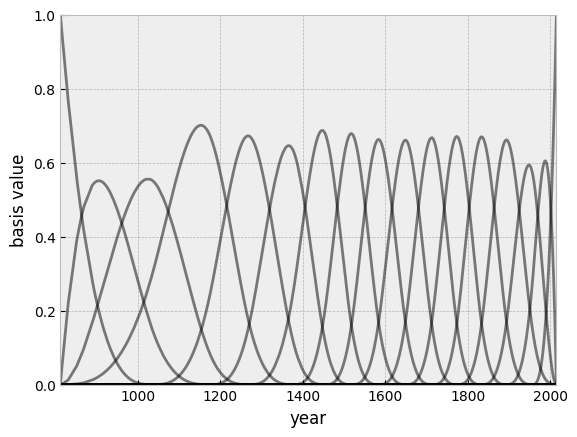

In [15]:
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

Next we define a linear model - the splines do all the work.

Each column of the basis matrix B will be a variable, and we'll add an intercept too. The mathematical form is:

$$
\begin{aligned}
D_i &\sim Normal(\mu_i, \sigma)\\
\mu_i &= \alpha + \sum_{k=1}^{K} w_k B_{k,i}
\end{aligned}
$$

Our priors:

$$
\begin{aligned}
\alpha &\sim Normal(100, 10)\\
w_j &\sim Normal(0, 10)\\
\sigma &\sim Exponential(1)\\
\end{aligned}
$$

In [16]:
import numpyro.optim as optim
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [17]:
# 4.76
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": jnp.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
svi_result = svi.run(random.PRNGKey(0), 20000)
p4_7 = svi_result.params

100%|██████████| 20000/20000 [00:01<00:00, 17387.90it/s, init loss: 2476234.7500, avg. loss [19001-20000]: 2705.3284]


Should see 17w parameters

In [18]:
p4_7

{'auto_loc': Array([103.340454  ,  -3.0235887 ,  -0.83700144,  -1.060741  ,
          4.8353395 ,  -0.8436172 ,   4.3158364 ,  -5.3246493 ,
          7.8361063 ,  -1.0076281 ,   3.0251174 ,   4.6610904 ,
         -0.160876  ,   5.554423  ,   0.708546  ,  -0.8075408 ,
         -6.964862  ,  -7.661019  ,   1.7238383 ], dtype=float32)}

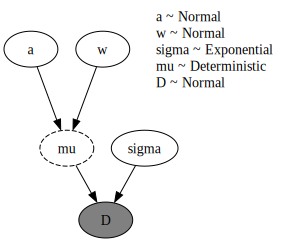

In [19]:
numpyro.render_model(model, (B, d2.doy.values,), render_distributions=True)

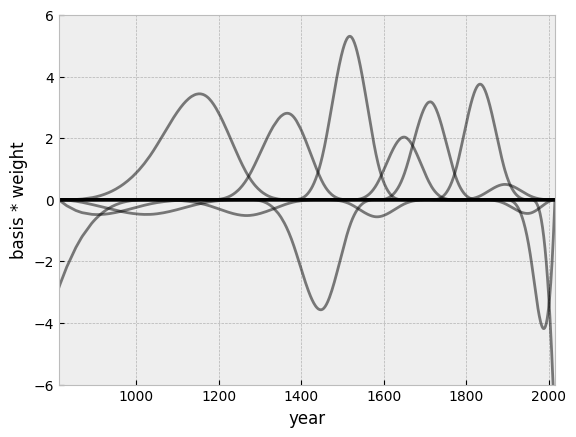

In [20]:
# 4.77
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000,))
w = jnp.mean(post["w"], 0)
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)

This plot is fig 4.13 (b). Each basis weighted by its corresponding parameter $w$.

But what we really care about is the sum of all of these:

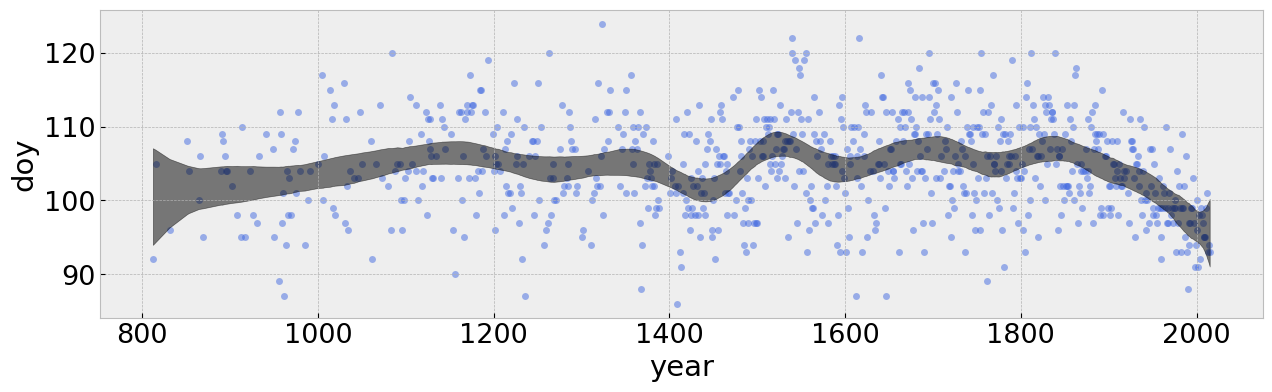

In [21]:
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 0.5, "s": 100}, figsize=(15,4)
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5)
plt.show()

## GLMs

A logistic regression example hiding in the [effect handlers](https://num.pyro.ai/en/stable/handlers.html) docs

Consider the logistic regression as a basic example of a GLM with a logit link function and a Bernoulli distribution.

$$
\begin{aligned}
y_i &\sim Bernoulli(p_i)\\
\text{logit}(p_i) &= X\beta\\
&\text{or equivalently,}\\
p_i &= \text{logit}^{-1}(X\beta)\\
&=\frac{\exp(X\beta)}{1+ \exp(X\beta)}
\end{aligned}
$$


In [23]:
N, D = 3000, 3

# Simulate data
data = random.normal(random.PRNGKey(999), (N, D))
true_coefs = jnp.array([1., 2., 3.])
# logits = jnp.sum(true_coefs * data + 10, axis=1)
logits = data @ true_coefs + 10
labels = dist.Bernoulli(logits=logits).sample(random.PRNGKey(0))

def logistic_regression(data, labels):
    D = data.shape[1]
    # Priors
    coefs = numpyro.sample('coefs', dist.Normal(jnp.zeros(D), jnp.ones(D)))
    intercept = numpyro.sample('intercept', dist.Normal(0., 10.))
    
    logits = data @ coefs + intercept
    # Don't need to return anything but here it is
    numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=labels)

The inverse of the logit function is the logistic sigmoid or `expit` function - which we can implement in `numpyro` using the `jax.scipy.special.expit` function for use in the `probs` argument for a `dist.Binomial` or `dist.Bernoulli` object.

Alternatively, the distribution classes accept an argument `logits` as an alternative to `probs` that don't require an `expit` transformation.


In [24]:
# Inference
model = logistic_regression
num_warmup, num_samples = 1000, 1000
mcmc = MCMC(NUTS(model=model), 
            num_warmup=num_warmup, 
            num_samples=num_samples)
mcmc.run(random.PRNGKey(2), data, labels)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:02<00:00, 723.37it/s, 7 steps of size 2.81e-01. acc. prob=0.93]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   coefs[0]      0.84      0.27      0.84      0.43      1.30    592.99      1.00
   coefs[1]      1.43      0.30      1.43      0.90      1.91    432.33      1.00
   coefs[2]      2.10      0.33      2.08      1.53      2.59    389.40      1.00
  intercept      8.24      0.73      8.17      7.08      9.43    321.84      1.00

Number of divergences: 0


In [25]:
## Prior Predictive Sampling
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, data, labels)['obs']
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

In [26]:
# Posterior Predictive Sampling
## get representative sample of posterior
posterior_samples = mcmc.get_samples()

## Posterior Predictive Sampling
rng_key_, rng_key_2 = random.split(rng_key_)
posterior_predictive = Predictive(model, posterior_samples=posterior_samples)
# Set target to None here
posterior_predictive_samples = posterior_predictive(rng_key_2, data=data, labels=None)['obs']
mean_posterior_pred = jnp.mean(posterior_predictive_samples, axis=0)
hpdi_posterior_pred = hpdi(posterior_predictive_samples, 0.9)

## Pima Diabetes Dataset

In [27]:
import statsmodels.api as sm
pima = sm.datasets.get_rdataset('Pima.tr', package='MASS').data
pima['outcome'] = (pima['type'] == 'Yes') * 1 # binary
pima.head()


,npreg,glu,bp,skin,bmi,ped,age,type,outcome
0,5,86,68,28,30.2,0.364,24,No,0
1,7,195,70,33,25.1,0.163,55,Yes,1
2,5,77,82,41,35.8,0.156,35,No,0
3,0,165,76,43,47.9,0.259,26,No,0
4,0,107,60,25,26.4,0.133,23,No,0


TODO: 

`type` is the outcome (if they had diabetes or not)

See https://drbeane.github.io/python_dsci/pages/logistic_regression.html for example on this dataset

In [28]:
# X = pima.iloc[:,:-1].values
X = pima[['npreg', 'glu', 'bp', 'bmi', 'ped']].values
y = pima.loc[:,'outcome'].values

In [29]:
from jax.scipy.special import expit

def logistic_regression(y, X, use_expit=True):
    N = X.shape[1]

    alpha = numpyro.sample('alpha', dist.Normal(0,1))
    beta = numpyro.sample('beta', dist.Normal(0,1).expand([N]))
    # Provide 2 methods - one with the `expit` function, and the other using the `logits` argument
    if use_expit:
        p = expit(alpha + X @ beta)
        obs = numpyro.sample('A', dist.Bernoulli(probs=p), obs=y)
    else:
        logit_p = alpha + X @ beta
        obs = numpyro.sample('A', dist.Bernoulli(logits=logit_p), obs=y)

# Inference using the expit function
num_warmup, num_samples = 1000, 1000
mcmc = MCMC(NUTS(model=logistic_regression), num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(random.PRNGKey(2), y=y, X=X, use_expit=True) 
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1357.13it/s, 63 steps of size 8.65e-02. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -3.10      0.80     -3.11     -4.35     -1.73    780.45      1.00
   beta[0]      0.16      0.05      0.16      0.07      0.24    563.38      1.00
   beta[1]      0.03      0.01      0.03      0.02      0.04    922.58      1.00
   beta[2]     -0.03      0.02     -0.03     -0.06     -0.01    479.29      1.01
   beta[3]      0.01      0.03      0.02     -0.03      0.06    552.80      1.00
   beta[4]      0.93      0.49      0.92      0.17      1.76    698.74      1.00

Number of divergences: 0


In [30]:
# The same model, but without the expit function and instead using the `logits` parameter
mcmc.run(random.PRNGKey(2), y=y, X=X, use_expit=False) 
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1423.92it/s, 63 steps of size 8.37e-02. acc. prob=0.95]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -3.09      0.80     -3.09     -4.46     -1.80    690.33      1.00
   beta[0]      0.16      0.05      0.16      0.07      0.24    486.88      1.00
   beta[1]      0.03      0.01      0.03      0.02      0.04    852.14      1.00
   beta[2]     -0.03      0.02     -0.03     -0.06     -0.01    427.90      1.00
   beta[3]      0.02      0.03      0.02     -0.03      0.07    541.04      1.00
   beta[4]      0.96      0.51      0.96      0.07      1.73    691.48      1.00

Number of divergences: 0


### Another Example with UCB Admissions

In [31]:
# Dataset of UCB Admission records by gender and department
UCBadmit = pd.read_csv("https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/UCBadmit.csv", sep=";")
d = UCBadmit
print(d.head())

dat_list = dict(
    admit=d.admit.values, # obs
    applications=d.applications.values, # N
    gid=(d["applicant.gender"] != "male").astype(int).values,
)
dat_list["dept_id"] = jnp.repeat(jnp.arange(6), 2)
dat_list

  dept applicant.gender  admit  reject  applications
1    A             male    512     313           825
2    A           female     89      19           108
3    B             male    353     207           560
4    B           female     17       8            25
5    C             male    120     205           325


{'admit': array([512,  89, 353,  17, 120, 202, 138, 131,  53,  94,  22,  24]),
 'applications': array([825, 108, 560,  25, 325, 593, 417, 375, 191, 393, 373, 341]),
 'gid': array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]),
 'dept_id': Array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], dtype=int32)}

In this example they're asking *what is the average difference in the probability of admission between women and men within departments?*:

$$
\begin{aligned}
A_i &\sim \text{Binomial}(N_i, p_i)\\
\text{logit}(p_i) &= \alpha_{\text{GID}[i]} + \delta_{\text{DEPT}[i]}\\
\alpha_j &\sim \mathcal{N}(0, 1.5)\\
\delta_k &\sim \mathcal{N}(0, 1.5)
\end{aligned}
$$

for $i \in \{0, 1\}$ (gender), and $j \in \{ 0,\dots, 5 \}$ (department)

In [32]:
def model(gid, dept_id, applications, admit=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    delta = numpyro.sample("delta", dist.Normal(0, 1.5).expand([6]))
    logit_p = a[gid] + delta[dept_id]
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)

m11_8 = MCMC(NUTS(model), num_warmup=2000, num_samples=2000, num_chains=1)
m11_8.run(random.PRNGKey(0), **dat_list)
m11_8.print_summary(0.89)

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2867.61it/s, 7 steps of size 8.38e-02. acc. prob=0.87] 



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.52      0.51     -0.53     -1.34      0.22    136.84      1.02
      a[1]     -0.42      0.52     -0.44     -1.26      0.31    137.85      1.02
  delta[0]      1.10      0.52      1.11      0.35      1.92    138.67      1.02
  delta[1]      1.05      0.52      1.07      0.23      1.86    139.09      1.02
  delta[2]     -0.16      0.52     -0.15     -0.91      0.66    137.33      1.02
  delta[3]     -0.19      0.52     -0.18     -0.96      0.61    142.66      1.02
  delta[4]     -0.64      0.52     -0.61     -1.44      0.16    138.52      1.02
  delta[5]     -2.20      0.52     -2.17     -3.06     -1.44    147.93      1.01

Number of divergences: 0
